# 0. Setup

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchinfo import summary
from helper_functions import set_seeds, plot_loss_curves, download_data

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Get data

In [3]:
import os 
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else: 
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download data
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading the data...")
    f.write(request.content)
    
# Extract the data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref: 
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)
    
# Remove zipfile
os.remove(data_path/"pizza_steak_sushi.zip")

data\pizza_steak_sushi directory exists.
Unzipping pizza, steak, sushi data...


In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

# 2. Create Datasets and DataLoaders

In [5]:
from torchvision import datasets
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloader(train_dir: str,
                      test_dir: str,
                      transform: transforms.Compose,
                      batch_size: int,
                      num_workers: int=NUM_WORKERS):
    
    # Use ImageFolder to create DataLoader
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
    
    # Get class names
    class_names = train_data.classes
    
    # Create train and test dataloader
    train_dataloader = DataLoader(dataset=train_data, 
                                  batch_size=batch_size,
                                  num_workers=NUM_WORKERS,
                                  pin_memory=True,
                                  shuffle=True)
    
    test_dataloader = DataLoader(dataset=test_data,
                                  batch_size=batch_size,
                                  num_workers=NUM_WORKERS,
                                  pin_memory=True,
                                  shuffle=False)
    
    return train_dataloader, test_dataloader, class_names

In [6]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
# Create the batch size
BATCH_SIZE = 32

# Create dataloaders
train_dataloader, test_dataloader, class_names = create_dataloader(train_dir=train_dir,
                                                                   test_dir=test_dir,
                                                                   transform=manual_transforms,
                                                                   batch_size=BATCH_SIZE)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x25262211a50>,
 ['pizza', 'steak', 'sushi'])

### 2.1 Visualize a single image

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get single image and label from batch
image, label = image_batch[0], label_batch[0]

# View thte batch shape
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

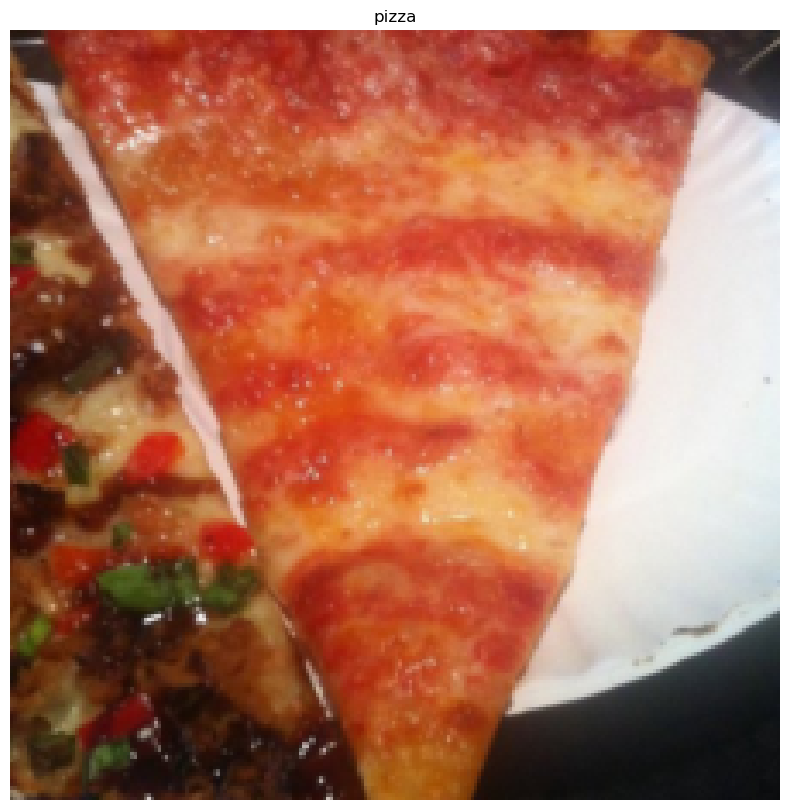

In [9]:
plt.figure(figsize=(15, 10))
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

# 3. Replicate the ViT paper: an overview

$\begin{aligned} \mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D} \\ \mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\ \mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\ \mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & & \end{aligned}$

# 4. Equation 1: Split data into patches and creating the class, position and patch embedding

If you can represent your data in a good, learnable way (as embeddings are learnable representations), chances are, a learning algorithm will be able to perform well on them.

The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

The image starts as 2D with size ${H \times W \times C}$.
* $(H, W)$ is the resolution of the original image (height, width).
* $C$ is the number of channels.

The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
* $(P, P)$ is the resolution of each image patch (patch size).
* $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

### 4.1 Calculating patch embedding input and output shapes by hand

In [10]:
# Create example values 
height = 224 # H
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / (patch_size**2))
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

In [11]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### 4.2 Turn a single image into patches

(-0.5, 223.5, 223.5, -0.5)

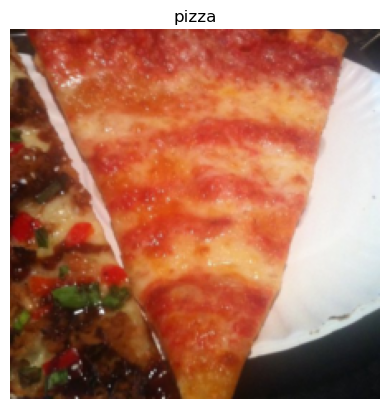

In [12]:
# view our single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

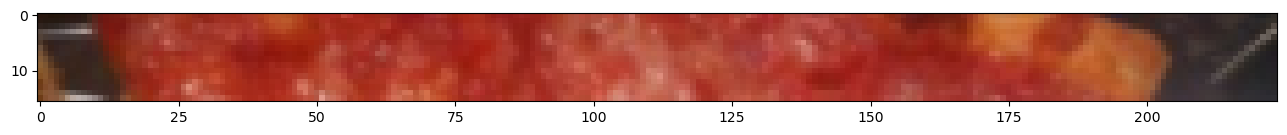

In [13]:
# Change image shape to be compatible with matplotlib 
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[: patch_size, :, :])

Number of patches per row: 14.0 
Patch size: 16 pizels x 16 pizels


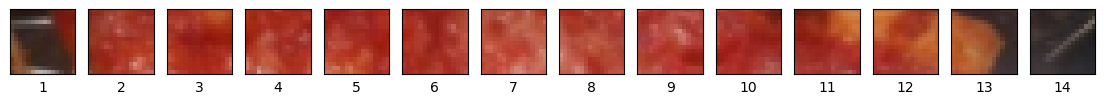

In [14]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches} \nPatch size: {patch_size} pizels x {patch_size} pizels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                         ncols=img_size // patch_size,
                         figsize=(num_patches, num_patches),
                         sharex=True, 
                         sharey=True)

# Iterate through number of patches in the top now
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [15]:
for i, patch in enumerate(range(0, img_size, patch_size)):
    print(i, patch)

0 0
1 16
2 32
3 48
4 64
5 80
6 96
7 112
8 128
9 144
10 160
11 176
12 192
13 208


Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


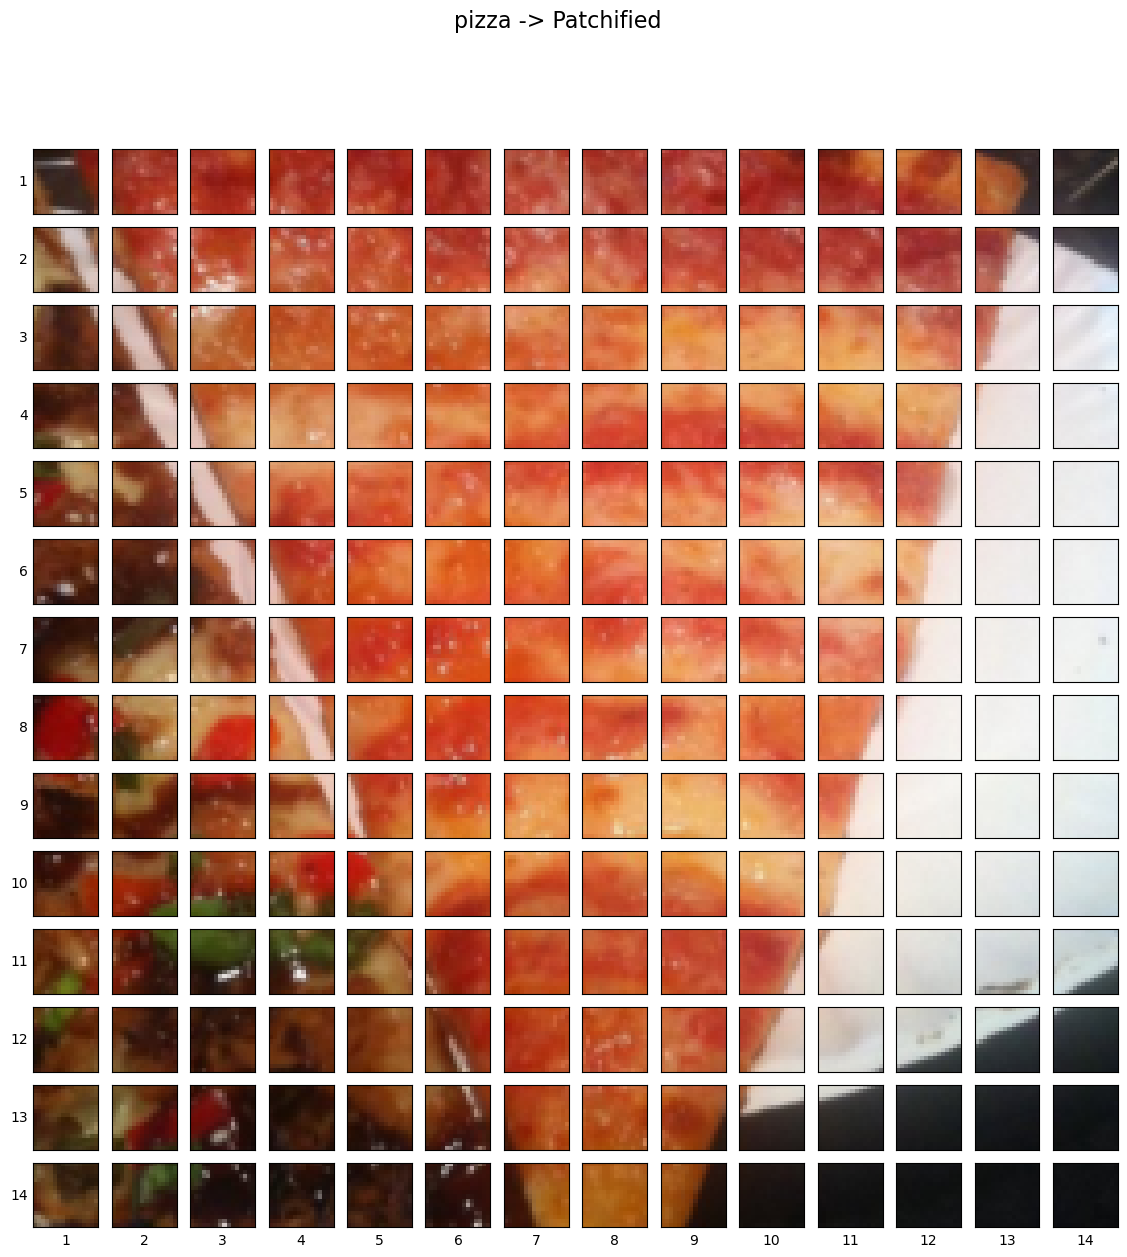

In [16]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size//patch_size, # need int not float
                        ncols=img_size//patch_size,
                        figsize=(num_patches, num_patches), 
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        
        # Plot the permuted image patch (image_permuted -> (height, width, color channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                         patch_width:patch_width+patch_size, # iterate through width
                                         :]) # get all color channels
        
        # Setup label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                           rotation="horizontal",
                           horizontalalignment="right",
                           verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
        
# Setup a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 4.3 Creating image patches with torch.nn.Conv2d()

**Hybrid Architecture:** As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection $\mathbf{E}$ (Eq. 1) is applied to patches extracted from a CNN feature map. As a special case, the patches can have spatial size $1 \times 1$, which means that the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension. The classification input embedding and position embeddings are added as described above. -> **the patch embedding is achievable with a convolutional neural network (CNN)**



The **"feature map"** they're refering to are the **weights/activations** produced by a convolutional layer passing over a given image.



By setting the **kernel_size** and **stride** parameters of a **torch.nn.Conv2d()** layer equal to the **patch_size**, we can effectively get a layer that splits our image into patches and creates a learnable embedding (referred to as a "Linear Projection" in the ViT paper) of each patch.



For an image size of 224 and patch size of 16:

* **Input (2D image):** (224, 224, 3) -> (height, width, color channels)
* **Output (flattened 2D patches):** (196, 768) -> (number of patches, embedding dimension)

We can recreate these with:
* torch.nn.Conv2d() for turning our image into patches of CNN feature maps.
* torch.nn.Flatten() for flattening the spatial dimensions of the feature map.

Let's start with the torch.nn.Conv2d() layer.

We can replicate the creation of patches by setting the **kernel_size** and **stride equal** to **patch_size**.

This means each convolutional kernel will be of size **(patch_size x patch_size)** or if patch_size=16, (16 x 16) <==> one whole patch.

And each step or **stride** of the convolutional kernel will be patch_size pixels long or 16 pixels long (equivalent of stepping to the next patch).

We'll set in_channels=3 for the number of color channels in our image and we'll set out_channels=768, the same as the $D$ value in Table 1 for ViT-Base (this is the embedding dimension, each image will be embedded into a learnable vector of size 768).

In [17]:
from torch import nn

# Set the patch size
patch_size = 16

# Create the Conv2d layer with hyperparameters from the Vit paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from table 1: Hidden size D, this is embedding size 
                   kernel_size=patch_size, # could alse use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)


(-0.5, 223.5, 223.5, -0.5)

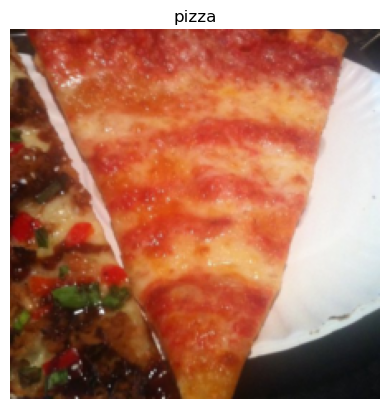

In [18]:
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)

In [19]:
image.shape

torch.Size([3, 224, 224])

In [20]:
# pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(dim=0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Passing our image through the convolutional layer turns it into a series of 768 (this is the embedding size or $D$) feature/activation maps.

torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]

Note: If you don’t actually need gradients, then you can explicitly **detach()** the Tensor that requires grad to get a tensor with the same content that does not require grad. This other Tensor can then be converted to a numpy array.
----> detach method means "I don't want gradients"

Showing random convolutional feature maps from indexes: [539, 421, 394, 611, 667]


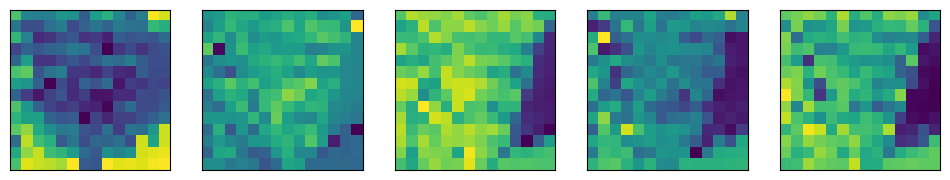

In [21]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5) # pick 5 numbers between 0 and 768(embedding size)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes): 
    img_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(img_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

The important thing to note is that these features may change over time as the neural network learns.

And because of these, these feature maps can be considered a learnable embedding of our image.

In [22]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0275, -0.1560, -0.1707, -0.1470, -0.1396, -0.1774, -0.2113,
           -0.1714, -0.1294, -0.1764, -0.1609, -0.1800, -0.1230, -0.0942],
          [-0.2787, -0.1753, -0.3042, -0.2373, -0.2004, -0.1816, -0.2495,
           -0.2146, -0.1831, -0.2032, -0.2194, -0.2198, -0.3205, -0.3381],
          [-0.1112, -0.2942, -0.1995, -0.1633, -0.1305, -0.1268, -0.2022,
           -0.2114, -0.2323, -0.2299, -0.2122, -0.2449, -0.3417, -0.4111],
          [-0.1420, -0.2037, -0.2459, -0.2616, -0.2251, -0.2170, -0.2162,
           -0.2088, -0.2250, -0.2109, -0.1939, -0.2702, -0.3956, -0.3998],
          [-0.0939, -0.1332, -0.3082, -0.2058, -0.2080, -0.2267, -0.2518,
           -0.2415, -0.2318, -0.2608, -0.2737, -0.2808, -0.4003, -0.4014],
          [-0.2008, -0.1165, -0.2060, -0.1746, -0.1489, -0.2294, -0.2226,
           -0.2255, -0.1975, -0.2440, -0.2179, -0.3831, -0.4003, -0.4056],
          [-0.0797, -0.1196, -0.1171, -0.2412, -0.1982, -0.1431, -0.1999,
           -0.2566, -0.2790, -0.

The `grad_fn` output of the `single_feature_map` and the `requires_grad=True` attribute means pytorch is tracking gradients of this feature map and it will be updated by gradient descent during training

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

> **Desired output (1D sequence of flattened 2D patches):** (196, 768) -> (number of patches, embedding dimension) -> ${N \times\left(P^{2} \cdot C\right)}$

In [23]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


Reading back through section 3.1 of the ViT paper it says (bold mine):
> As a special case, the patches can have spatial size 1x1, which means that the **input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension.**

But we don't want to flatten the whole tensor, we only want to flatten the "spatial dimensions of the feature map".

Which in our case is the `feature_map_height` and `feature_map_width` dimensions of `image_out_of_conv`

In [24]:
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

1. Take a single image.
2. Put it through the convolutional layer(`conv2d`) to turn the image into 2D feature maps (patch embeddings)
3. Flatten the 2D feature map into a single sequence.

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


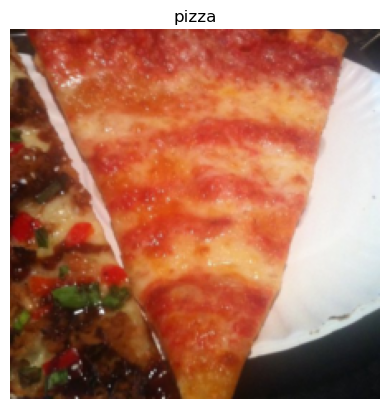

In [25]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(dim=0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [26]:
# Get flattened image patch embeddings in right place
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


(-0.5, 195.5, 0.5, -0.5)

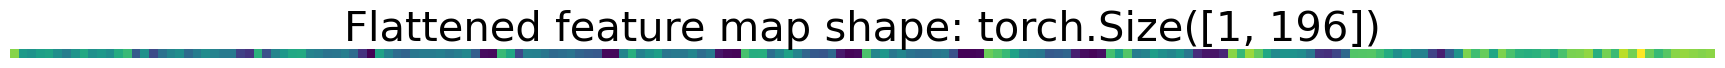

In [27]:
# Get a single flattened feature map 
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}", fontsize=30)
plt.axis(False)

In [28]:
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.0275, -0.1560, -0.1707, -0.1470, -0.1396, -0.1774, -0.2113, -0.1714,
          -0.1294, -0.1764, -0.1609, -0.1800, -0.1230, -0.0942, -0.2787, -0.1753,
          -0.3042, -0.2373, -0.2004, -0.1816, -0.2495, -0.2146, -0.1831, -0.2032,
          -0.2194, -0.2198, -0.3205, -0.3381, -0.1112, -0.2942, -0.1995, -0.1633,
          -0.1305, -0.1268, -0.2022, -0.2114, -0.2323, -0.2299, -0.2122, -0.2449,
          -0.3417, -0.4111, -0.1420, -0.2037, -0.2459, -0.2616, -0.2251, -0.2170,
          -0.2162, -0.2088, -0.2250, -0.2109, -0.1939, -0.2702, -0.3956, -0.3998,
          -0.0939, -0.1332, -0.3082, -0.2058, -0.2080, -0.2267, -0.2518, -0.2415,
          -0.2318, -0.2608, -0.2737, -0.2808, -0.4003, -0.4014, -0.2008, -0.1165,
          -0.2060, -0.1746, -0.1489, -0.2294, -0.2226, -0.2255, -0.1975, -0.2440,
          -0.2179, -0.3831, -0.4003, -0.4056, -0.0797, -0.1196, -0.1171, -0.2412,
          -0.1982, -0.1431, -0.1999, -0.2566, -0.2790, -0.2856, -0.2519, -0.3769,
          -0.404

### 4.5 Turning the ViT patch embedding layer into a Pytorch module

In [29]:
class PatchEmpdding(nn.Module): 
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels: int=3, 
                 patch_size: int=16, 
                 embedding_dim: int=768):
        super().__init__()
        
        # 3. Create a layer to turn image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, end_dim=3) # only flatten the feature map dimension into a single vector
    
    # 5. Define a forward method
    def forward(self, x):
        
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisable by patch size, image shape: {image_resolution}, patch_size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattended = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattended.permute(0, 2, 1)

In [30]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmpdding(in_channels=3, patch_size=16, embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(dim=0).shape}")
patch_embedded_image = patchify(image.unsqueeze(dim=0)) # add an extra batch dimension
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [31]:
# Create random input sizes 
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is imcompatible with patch_size


# Get a summary of the input and outputs of PatchEmbedding
summary(model=PatchEmpdding(), 
        input_size=(random_input_image), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmpdding (PatchEmpdding)            [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### 4.6 Creating the class token embedding

In [33]:
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, num_patch, embedding_size]")

tensor([[[-0.3176, -0.0041, -0.1720,  ...,  0.1169, -0.1224,  0.1116],
         [-0.5420,  0.0366, -0.0048,  ...,  0.2777, -0.2501,  0.1885],
         [-0.4181, -0.0455,  0.0234,  ...,  0.1791, -0.2486,  0.1869],
         ...,
         [-0.0823,  0.0138, -0.0528,  ...,  0.0683, -0.0416,  0.0268],
         [-0.0775,  0.0112, -0.0517,  ...,  0.0678, -0.0252,  0.0285],
         [-0.0802,  0.0089, -0.0433,  ...,  0.0599, -0.0349,  0.0213]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, num_patch, embedding_size]


**In pseudocode:**

patch_embedding = [image_patch_1, image_patch_2, image_patch_3...]

class_token = learnable_embedding

patch_embedding_with_class_token = torch.cat((class_token, 
patch_embedding), dim=1)

>Notice the concatenation (`torch.cat()`) happens on `dim=1` (the `number_of_patches` dimension).

In [35]:
# Get the batch_size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter the shares the same size as them embedding dimension $D$
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, num_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Print the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, num_of_tokens, embedding dimension]")


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, num_of_tokens, embedding dimension]


> Note: Here we're only creating the class token embedding as `torch.ones()` for demonstration purposes, in reality, you'd likely create the class token embedding with `torch.randn()` *(since machine learning is all about harnessing the power of controlled randomness, you generally start with a random number and improve it over time)*.

In [39]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.3176, -0.0041, -0.1720,  ...,  0.1169, -0.1224,  0.1116],
         [-0.5420,  0.0366, -0.0048,  ...,  0.2777, -0.2501,  0.1885],
         ...,
         [-0.0823,  0.0138, -0.0528,  ...,  0.0683, -0.0416,  0.0268],
         [-0.0775,  0.0112, -0.0517,  ...,  0.0678, -0.0252,  0.0285],
         [-0.0802,  0.0089, -0.0433,  ...,  0.0599, -0.0349,  0.0213]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 4.7 Creating the position embedding

By "retain positional information" the authors mean they **want the architecture to know what "order" the patches come in**. As in, patch two comes after patch one and patch three comes after patch two and on and on.

This positional information can be important when considering what's in an image (without positional information an a flattened sequence could be seen as having no order and thus no patch relates to any other patch).

In [41]:
# View the sequence of patch embedding with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.3176, -0.0041, -0.1720,  ...,  0.1169, -0.1224,  0.1116],
          [-0.5420,  0.0366, -0.0048,  ...,  0.2777, -0.2501,  0.1885],
          ...,
          [-0.0823,  0.0138, -0.0528,  ...,  0.0683, -0.0416,  0.0268],
          [-0.0775,  0.0112, -0.0517,  ...,  0.0678, -0.0252,  0.0285],
          [-0.0802,  0.0089, -0.0433,  ...,  0.0599, -0.0349,  0.0213]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))